In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## minimize wait time target×priority score
### Assign patients to available doctors and rooms based on priority
### high-priority cases (e.g., emergency) are scheduled first

### look at the dataset

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/healthcare_scheduling_combined_view_sample_1000 1.csv')

# Get unique values from the 'required_resources' column
unique_resources = df['required_resources'].unique()

# Split each entry by comma and flatten the list
split_resources = [resource.strip() for sublist in unique_resources for resource in sublist.split(',')]

# Get unique strings
unique_strings = set(split_resources)

# Print the unique resources
print(unique_strings)

{'EmergencyDoctor', 'GeneralDoctor', 'EmergencyRoom', 'Specialist', 'TreatmentRoom', 'ConsultationRoom'}


In [ ]:
data = df
# Convert 'scheduled_date' to datetime format and 'scheduled_time' to time format
data['scheduled_date'] = pd.to_datetime(data['scheduled_date'])
data['scheduled_time'] = pd.to_datetime(data['scheduled_time'], format='%H:%M').dt.time

# Ensure 'duration_minutes', 'priority_score', and 'wait_time_target' are integers
data['duration_minutes'] = data['duration_minutes'].astype(int)
data['priority_score'] = data['priority_score'].astype(int)
data['wait_time_target'] = data['wait_time_target'].astype(int)

# Display the cleaned data
print(data.head())

  patient_id scheduled_date scheduled_time  duration_minutes  \
0    P000666     2024-08-30       12:30:00                56   
1    P000129     2024-08-28       15:00:00                25   
2    P000784     2024-08-24       17:00:00                69   
3    P000152     2024-08-10       09:00:00                83   
4    P000920     2024-08-25       11:15:00                34   

               required_resources  priority_score condition_type  \
0        TreatmentRoom,Specialist              62         Urgent   
1  ConsultationRoom,GeneralDoctor              32        Routine   
2        TreatmentRoom,Specialist              65         Urgent   
3        TreatmentRoom,Specialist              55         Urgent   
4   EmergencyRoom,EmergencyDoctor              79      Emergency   

   wait_time_target  
0               120  
1               240  
2               120  
3               120  
4                30  


## Visualize with sample resources

In [ ]:
class HospitalGraph:
    def __init__(self, data_path, hospital_resources):
        # Load data from CSV
        self.data = pd.read_csv(data_path)
        self.graph = nx.DiGraph()  # Directed graph for resource flow
        self.hospital_resources = hospital_resources  # Store hospital resources
        self.resource_schedules = {resource: {} for category in hospital_resources.values() for resource in category}

        # Define a mapping from specific resource types to their categories
        self.resource_mapping = {
            "TreatmentRoom": "TreatmentRooms",
            "Specialist": "Specialists",
            "ConsultationRoom": "ConsultationRooms",
            "GeneralDoctor": "GeneralDoctors",
            "EmergencyRoom": "EmergencyRooms",
            "EmergencyDoctor": "EmergencyDoctors"
        }

    def create_base_graph(self):
        # Extract unique resources from the dataset
        unique_resources = set()
        for _, row in self.data.iterrows():
            resources = row['required_resources'].split(',')
            unique_resources.update([r.strip() for r in resources])

        # Add resource nodes to the graph
        for resource in unique_resources:
            self.graph.add_node(f"Resource_{resource}", type='resource', capacity=1, schedule={})

        # Add patient nodes and connect them to required resources
        for _, row in self.data.iterrows():
            patient_node = f"Patient_{row['patient_id']}"
            self.graph.add_node(
                patient_node,
                type='patient',
                priority_score=row['priority_score'],
                condition_type=row['condition_type'],
                wait_time_target=row['wait_time_target'],
                duration=row['duration_minutes'],
                scheduled_time=f"{row['scheduled_date']} {row['scheduled_time']}",
                required_resources=row['required_resources']
            )
            # Connect patient to required resources
            resources = row['required_resources'].split(',')
            for resource in resources:
                resource_node = f"Resource_{resource.strip()}"
                self.graph.add_edge(patient_node, resource_node, weight=row['priority_score'])


    def optimize_assignments(self):
        """Optimize assignments of patients to specific resources."""
        patients = [(node, attr) for node, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']

        # Sort patients by priority score (descending) and wait time target (ascending)
        patients.sort(key=lambda x: (-x[1]['priority_score'], x[1]['wait_time_target']))

        assignments = {}
        print(patients[0])


        for patient, attr in patients:
            required_resources = attr['required_resources'].split(',')
            scheduled_time = datetime.strptime(attr['scheduled_time'], '%Y-%m-%d %H:%M')
            duration = attr['duration']

            for resource_type in required_resources:
                # Use the mapping to get the correct category
                resource_category = self.resource_mapping.get(resource_type.strip())
                if not resource_category:
                    raise KeyError(f"Resource type '{resource_type}' not found in resource mapping.")

                available_resource = None
                min_wait_time = float('inf')

                # Check availability of specific resources within the category
                for specific_resource in self.hospital_resources[resource_category]:
                    resource_schedule = self.resource_schedules[specific_resource]
                    available_start = self._find_next_available_slot(resource_schedule, scheduled_time, duration)

                    wait_time = (available_start - scheduled_time).total_seconds() / 60
                    if wait_time < min_wait_time:
                        min_wait_time = wait_time
                        available_resource = specific_resource

                if available_resource:
                    # Assign this resource to the patient
                    assignments[patient] = {
                        'resource': available_resource,
                        'start_time': available_start,
                        'duration': duration,
                    }
                    # Update the resource's schedule
                    self._update_resource_schedule(available_resource, available_start, duration)

                    # Add edge between patient and specific resource in the graph
                    self.graph.add_edge(patient, f"Resource_{available_resource}", weight=attr['priority_score'])

        return assignments

    def _find_next_available_slot(self, schedule, desired_time, duration):
        """Find the next available time slot for a resource."""
        if not schedule:
            return desired_time

        current_time = desired_time
        while True:
            conflict = False
            for start, end in schedule.items():
                if start <= current_time < end or start < current_time + timedelta(minutes=duration) <= end:
                    current_time = end  # Adjust to the end of conflicting slot
                    conflict = True
                    break

            if not conflict:
                return current_time

    def _update_resource_schedule(self, resource, start_time, duration):
        """Update the schedule of a specific resource."""
        end_time = start_time + timedelta(minutes=duration)
        self.resource_schedules[resource][start_time] = end_time


('Patient_P000993', {'type': 'patient', 'priority_score': 89, 'condition_type': 'Emergency', 'wait_time_target': 30, 'duration': 30, 'scheduled_time': '2024-08-25 18:45', 'required_resources': 'EmergencyRoom,EmergencyDoctor'})


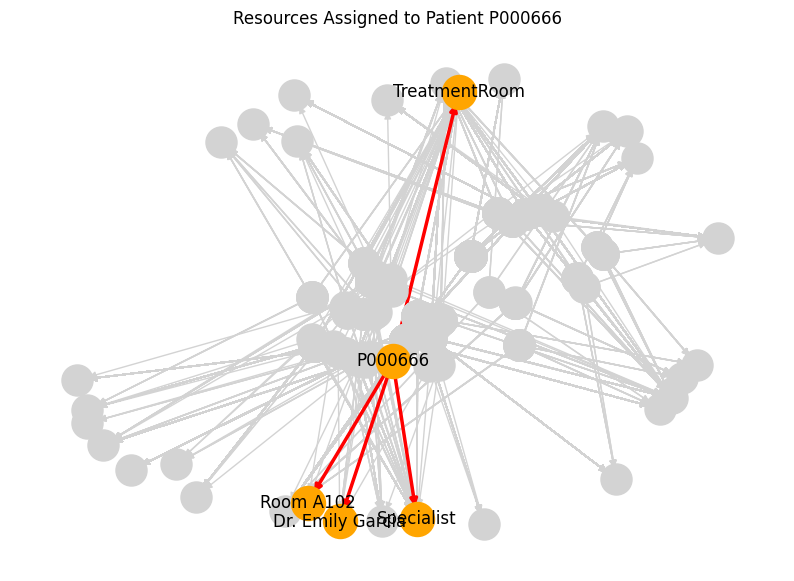

In [ ]:
# Visualize
def visualize_patient_specific_resources(graph, patient_id):
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph.graph)

    patient_node = f"Patient_{patient_id}"
    edges_to_highlight = [(u, v) for u, v in graph.graph.edges() if u == patient_node]

    nodes_to_highlight = [patient_node] + [v for u, v in edges_to_highlight]

    # Draw all nodes and edges in light gray
    nx.draw_networkx_nodes(graph.graph, pos, node_color='lightgray', node_size=500)
    nx.draw_networkx_edges(graph.graph, pos, edge_color='lightgray', arrows=True)

    # Highlight specific nodes and edges
    nx.draw_networkx_nodes(graph.graph, pos, nodelist=nodes_to_highlight, node_color='orange', node_size=600)
    nx.draw_networkx_edges(graph.graph, pos, edgelist=edges_to_highlight, edge_color='red', width=2.5)

    # Add labels
    labels = {node: node.split('_')[1] for node in nodes_to_highlight}
    nx.draw_networkx_labels(graph.graph, pos, labels)

    plt.title(f"Resources Assigned to Patient {patient_id}")
    plt.axis('off')
    plt.show()

# hospital resources
hospital_resources = {
    "TreatmentRooms": [
        "Room A101", "Room A102", "Room A103", "Room A104",
        "Room A105", "Room A106", "Room A107"
    ],
    "Specialists": [
        "Dr. Sarah Thompson", "Dr. Emily Garcia",
        "Dr. Alex Chen", "Dr. Rachel Adams"
    ],
    "ConsultationRooms": [
        "Consultation Room 1", "Consultation Room 2", "Consultation Room 3",
        "Consultation Room 4", "Consultation Room 5"
    ],
    "GeneralDoctors": [
        "Dr. Michael Brown", "Dr. Linda Johnson", "Dr. Robert Wilson"
    ],
    "EmergencyRooms": [
        "ER Room 1", "ER Room 2", "ER Room 3", "ER Room 4", "ER Room 5"
    ],
    "EmergencyDoctors": [
        "Dr. Jessica Martinez", "Dr. David Kim"
    ]
}

# Save the resources
with open("hospital_resources.json", "w") as f:
    json.dump(hospital_resources, f, indent=4)

hospital_graph = HospitalGraph("/content/healthcare_scheduling_combined_view_sample_1000 1.csv", hospital_resources)
hospital_graph.create_base_graph()
assignments = hospital_graph.optimize_assignments()


visualize_patient_specific_resources(hospital_graph, "P000666")


### Approach 2


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json

class HospitalGraph:
    def __init__(self, data_path, hospital_resources):
        # Load data from CSV
        self.data = pd.read_csv(data_path)
        self.graph = nx.DiGraph()  # Directed graph for resource flow
        self.hospital_resources = hospital_resources  # Store hospital resources
        self.resource_schedules = {resource: [] for category in hospital_resources.values() for resource in category}

        # Define a mapping from specific resource types to their categories
        self.resource_mapping = {
            "TreatmentRoom": "TreatmentRooms",
            "Specialist": "Specialists",
            "ConsultationRoom": "ConsultationRooms",
            "GeneralDoctor": "GeneralDoctors",
            "EmergencyRoom": "EmergencyRooms",
            "EmergencyDoctor": "EmergencyDoctors"
        }

    def create_base_graph(self):
        # Extract unique resources from the dataset
        unique_resources = set()
        for _, row in self.data.iterrows():
            resources = row['required_resources'].split(',')
            unique_resources.update([r.strip() for r in resources])

        # Add resource nodes to the graph
        for resource in unique_resources:
            self.graph.add_node(f"Resource_{resource}", type='resource', capacity=1, schedule=[])

        # Add patient nodes and connect them to required resources
        for _, row in self.data.iterrows():
            patient_node = f"Patient_{row['patient_id']}"
            self.graph.add_node(
                patient_node,
                type='patient',
                priority_score=row['priority_score'],
                condition_type=row['condition_type'],
                wait_time_target=row['wait_time_target'],
                duration=row['duration_minutes'],
                scheduled_time=f"{row['scheduled_date']} {row['scheduled_time']}",
                required_resources=row['required_resources']
            )
            # Connect patient to required resources
            resources = row['required_resources'].split(',')
            for resource in resources:
                resource_node = f"Resource_{resource.strip()}"
                self.graph.add_edge(patient_node, resource_node, weight=row['priority_score'])

    def optimize_assignments(self):
        """Optimize assignments of patients to specific resources."""
        patients = [(node, attr) for node, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']

        # Sort patients by priority score (descending) and wait time target (ascending)
        patients.sort(key=lambda x: (-x[1]['priority_score'], x[1]['wait_time_target']))

        assignments = {}

        for patient, attr in patients:
            required_resources = attr['required_resources'].split(',')
            scheduled_time = datetime.strptime(attr['scheduled_time'], '%Y-%m-%d %H:%M')
            duration = attr['duration']

            for resource_type in required_resources:
                resource_category = self.resource_mapping.get(resource_type.strip())
                if not resource_category:
                    raise KeyError(f"Resource type '{resource_type}' not found in resource mapping.")

                available_resource = None
                min_wait_time = float('inf')

                # Check availability of specific resources within the category
                for specific_resource in self.hospital_resources[resource_category]:
                    resource_schedule = self.resource_schedules[specific_resource]
                    available_start = self._find_next_available_slot(resource_schedule, scheduled_time, duration)

                    wait_time = (available_start - scheduled_time).total_seconds() / 60
                    if wait_time < min_wait_time:
                        min_wait_time = wait_time
                        available_resource = specific_resource

                if available_resource:
                    # Assign this resource to the patient
                    assignments[patient] = {
                        'resource': available_resource,
                        'start_time': available_start,
                        'duration': duration,
                        'scheduled_time': scheduled_time
                    }
                    # Update the resource's schedule
                    self._update_resource_schedule(available_resource, available_start, duration)

                    # Add edge between patient and specific resource in the graph
                    self.graph.add_edge(patient, f"Resource_{available_resource}", weight=attr['priority_score'])

        return assignments

    def _find_next_available_slot(self, schedule, desired_time, duration):
        """Find the next available time slot for a resource."""
        if not schedule:
            return desired_time

        current_time = desired_time
        while True:
            conflict = False
            for start, end in schedule:
                if start <= current_time < end or start < current_time + timedelta(minutes=duration) <= end:
                    current_time = end  # Adjust to the end of conflicting slot
                    conflict = True
                    break

            if not conflict:
                return current_time

    def _update_resource_schedule(self, resource, start_time, duration):
        """Update the schedule of a specific resource."""
        end_time = start_time + timedelta(minutes=duration)
        self.resource_schedules[resource].append((start_time, end_time))

    def a_star_algorithm(self, start_patient, end_patient):
        """Implement the A* algorithm to find the shortest path for a patient."""
        open_set = {start_patient}
        came_from = {}
        g_score = {node: float('inf') for node in self.graph.nodes}
        g_score[start_patient] = 0
        f_score = {node: float('inf') for node in self.graph.nodes}
        f_score[start_patient] = self.heuristic(start_patient, end_patient)

        while open_set:
            current = min(open_set, key=lambda x: f_score[x])

            if current == end_patient:
                return self.reconstruct_path(came_from, current)

            open_set.remove(current)

            for neighbor in self.graph.neighbors(current):
                tentative_g_score = g_score[current] + self.graph[current][neighbor]['weight']

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor, end_patient)
                    if neighbor not in open_set:
                        open_set.add(neighbor)

        return []

    def heuristic(self, node, end_node):
        """Heuristic function for A* (can be adjusted based on specific needs)."""
        return 0  # Placeholder for heuristic; can be improved based on actual data

    def reconstruct_path(self, came_from, current):
        """Reconstruct the path from the A* algorithm."""
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.append(current)
        return total_path[::-1]

    def optimize_patient_flow(self):
        """Main method to optimize patient flow using A* algorithm."""
        results = {}
        for patient in self.graph.nodes:
            # print(self.graph.nodes[patient])
            # if self.graph.nodes[patient]['type'] == 'patient':
            if self.graph.nodes[patient].get('type') == 'patient':
                # Assuming the end patient is the last resource in the graph
                end_patient = list(self.graph.nodes)[-1]
                path = self.a_star_algorithm(patient, end_patient)
                results[patient] = path
        return results



In [ ]:
def generate_daily_reports(data_path, hospital_resources):
    # Load the data
    data = pd.read_csv(data_path)

    # Convert scheduled_date to datetime and sort by newest to oldest
    data['scheduled_date'] = pd.to_datetime(data['scheduled_date'])
    unique_dates = data['scheduled_date'].unique().tolist()
    unique_dates.sort(reverse=True)  # Sort from newest to oldest

    reports = []

    for date in unique_dates:
        # Filter data for the current date
        daily_data = data[data['scheduled_date'] == date]

        # Create a temporary CSV for the current date
        daily_data_path = f"daily_data_{date.strftime('%Y-%m-%d')}.csv"
        daily_data.to_csv(daily_data_path, index=False)

        # Create a new HospitalGraph instance for the current date
        hospital_graph = HospitalGraph(daily_data_path, hospital_resources)
        hospital_graph.create_base_graph()
        # print(hospital_graph.graph.nodes(data=True))
        assignments = hospital_graph.optimize_assignments()
        optimized_paths = hospital_graph.optimize_patient_flow()

        # Generate report for the current date
        report = {
            "Processing Date": date.strftime('%Y-%m-%d'),
            "Initial Rooms and Wait Time": {
                "Rooms": {resource: 0 for resource in hospital_resources.keys()},
                "Cost": 1.00,
                "Average Wait Time": 0.00
            },
            "Optimized Rooms and Wait Time": {
                "Rooms": {resource: 0 for resource in hospital_resources.keys()},
                "Cost": 1.00,
                "Average Wait Time": 0.00
            },
            "Paths": []
        }

        for patient, initial in assignments.items():
            optimized = optimized_paths.get(patient, [])
            wait_time = (initial['start_time'] - initial['scheduled_time']).total_seconds() / 60
            report["Paths"].append({
                "Patient": patient.split('_')[1],
                "Wait Time": wait_time,
                "ResourcesUsed": initial['resource']
            })

        reports.append(report)

    return reports

# hospital resources
hospital_resources = {
    "TreatmentRooms": [
        "Room A101", "Room A102", "Room A103", "Room A104",
        "Room A105", "Room A106", "Room A107"
    ],
    "Specialists": [
        "Dr. Sarah Thompson", "Dr. Emily Garcia",
        "Dr. Alex Chen", "Dr. Rachel Adams"
    ],
    "ConsultationRooms": [
        "Consultation Room 1", "Consultation Room 2", "Consultation Room 3",
        "Consultation Room 4", "Consultation Room 5"
    ],
    "GeneralDoctors": [
        "Dr. Michael Brown", "Dr. Linda Johnson", "Dr. Robert Wilson"
    ],
    "EmergencyRooms": [
        "ER Room 1", "ER Room 2", "ER Room 3", "ER Room 4", "ER Room 5"
    ],
    "EmergencyDoctors": [
        "Dr. Jessica Martinez", "Dr. David Kim"
    ]
}


data_path = "/content/healthcare_scheduling_combined_view_sample_1000 1.csv"
daily_reports = generate_daily_reports(data_path, hospital_resources)

# Print the reports
for report in daily_reports:
    print(report)

{'Processing Date': '2024-08-31', 'Initial Rooms and Wait Time': {'Rooms': {'TreatmentRooms': 0, 'Specialists': 0, 'ConsultationRooms': 0, 'GeneralDoctors': 0, 'EmergencyRooms': 0, 'EmergencyDoctors': 0}, 'Cost': 1.0, 'Average Wait Time': 0.0}, 'Optimized Rooms and Wait Time': {'Rooms': {'TreatmentRooms': 0, 'Specialists': 0, 'ConsultationRooms': 0, 'GeneralDoctors': 0, 'EmergencyRooms': 0, 'EmergencyDoctors': 0}, 'Cost': 1.0, 'Average Wait Time': 0.0}, 'Paths': [{'Patient': 'P000427', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000741', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000958', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000889', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000749', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000916', 'Wait Time': 0.0, 'ResourcesUsed': 'Dr. Jessica Martinez'}, {'Patient': 'P000467', 'Wait Time'

{
   "Processing Date":"2024-08-02",
   "Initial Rooms and Wait Time":{
      "Rooms":{
         "TreatmentRooms":0,
         "Specialists":0,
         "ConsultationRooms":0,
         "GeneralDoctors":0,
         "EmergencyRooms":0,
         "EmergencyDoctors":0
      },
      "Cost":1.0,
      "Average Wait Time":0.0
   },
   "Optimized Rooms and Wait Time":{
      "Rooms":{
         "TreatmentRooms":0,
         "Specialists":0,
         "ConsultationRooms":0,
         "GeneralDoctors":0,
         "EmergencyRooms":0,
         "EmergencyDoctors":0
      },
      "Cost":1.0,
      "Average Wait Time":0.0
   },
   "Paths":[
      {
         "Patient":"P000463",
         "Wait Time":0.0,
         "ResourcesUsed":"Dr. Michael Brown"
      }
   ]
}


patient_id	scheduled_date	scheduled_time	duration_minutes	required_resources	priority_score	condition_type	wait_time_target
P000463	2024-08-02	09:00	27	ConsultationRoom,GeneralDoctor	35	Routine	240


## Approach 3


### Assumptions:
- Doctors working hours "working_hours": {"start": "08:00", "end": "17:00"}


- Associate efficiency with each Doctor (example Eff=95%) by coming up with a formula to use the "well_rested_score", "overtime_hours" parameters, "lunch_break", and "patients_seen_today" count.


- Factors that would reduce efficiency: no lunch break, less rested, overtime. "patients_seen_today" count for GeneralDoctors should reduce efficiency by g1, "patients_seen_today" count for Specialists should reduce efficiency by s1, "patients_seen_today" count for

- EmergencyDoctors should reduce efficiency by e1 such that g1 < s1 < e1.


- sort the doctors list by efficiency, and keep de-prioritizing doctors with lesser efficiency.
- in the dataset csv attached, if a patient required_resources column says: "ConsultationRoom,GeneralDoctor", that means that both one ConsultationRoom and one GeneralDoctor is required to handle that patient. similarly for "TreatmentRoom,Specialist" and "EmergencyRoom,EmergencyDoctor".
- for each of the 3 room types, consider the "cleaning_time" minutes before assigning it to next patient. this should be adjusted in wait time.

# code


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class HospitalGraph:
    def __init__(self, data_path, hospital_resources, date):
        # Load data from CSV
        self.data = pd.read_csv(data_path)
        self.data['scheduled_date'] = pd.to_datetime(self.data['scheduled_date'])  # Convert to datetime

        # Filter data by date
        self.data = self.data[self.data['scheduled_date'] == pd.to_datetime(date)]

        # Check if data is empty for the given date
        if self.data.empty:
            print(f"No data found for {date}")
            return
        self.graph = nx.DiGraph()  # Directed graph for resource flow
        self.hospital_resources = hospital_resources  # Store hospital resources

        #self.resource_schedules = {resource: [] for category in hospital_resources.values() for resource in category}
        self.resource_schedules = {}
        for category, resources in hospital_resources.items():
            for resource in resources:
                if category in ["TreatmentRooms", "ConsultationRooms", "EmergencyRooms"]:
                    self.resource_schedules[resource["room_id"]] = []
                elif category in ["Specialists", "GeneralDoctors", "EmergencyDoctors"]:
                    self.resource_schedules[resource["doctor_name"]] = []


        # Define a mapping from specific resource types to their categories
        self.resource_mapping = {
            "TreatmentRoom": "TreatmentRooms",
            "Specialist": "Specialists",
            "ConsultationRoom": "ConsultationRooms",
            "GeneralDoctor": "GeneralDoctors",
            "EmergencyRoom": "EmergencyRooms",
            "EmergencyDoctor": "EmergencyDoctors"
        }

    def create_base_graph(self):
        # Extract unique resources from the dataset
        unique_resources = set()
        for _, row in self.data.iterrows():
            resources = row['required_resources'].split(',')
            unique_resources.update([r.strip() for r in resources])

        # # Add resource nodes to the graph
        # for resource in unique_resources:
        #     self.graph.add_node(f"Resource_{resource}", type='resource', capacity=1, schedule=[])
        # Add resource nodes - only specific resources
        for category, resources in self.hospital_resources.items():
            for resource in resources:
                resource_key = resource.get('room_id') or resource.get('doctor_name')
                self.graph.add_node(f"Resource_{resource_key}", type='resource', capacity=1, schedule=[])

        # Add patient nodes and connect them to required resources
        for _, row in self.data.iterrows():
            patient_node = f"Patient_{row['patient_id']}"
            self.graph.add_node(
                patient_node,
                type='patient',
                patient_id=row['patient_id'],
                priority_score=row['priority_score'],
                condition_type=row['condition_type'],
                wait_time_target=row['wait_time_target'],
                duration=row['duration_minutes'],
                scheduled_time=f"{row['scheduled_date']} {row['scheduled_time']}",
                required_resources=row['required_resources']
            )

            # Connect patient to required resources
            resources = row['required_resources'].split(',')
            for resource_type in resources:
                resource_category = self.resource_mapping.get(resource_type.strip())
                # Find the specific resource from the hospital_resources dictionary
                specific_resource = next((r for r in self.hospital_resources[resource_category] if resource_type.strip() in r.values()), None)
                if specific_resource:
                    resource_key = specific_resource.get('room_id') or specific_resource.get('doctor_name')  # Get the key for the resource
                    resource_node = f"Resource_{resource_key}"
                    self.graph.add_edge(patient_node, resource_node, weight=row['priority_score'])

    def optimize_assignments(self):
        """Optimize assignments of patients to specific resources."""
        patients = [(node, attr) for node, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']

        # Sort patients by priority score (descending) and wait time target (ascending)
        # patients.sort(key=lambda x: (-x[1]['priority_score'], x[1]['wait_time_target']))
        patients.sort(key=lambda x: (
            pd.to_datetime(x[1]['scheduled_time']).to_pydatetime(),  # scheduled_time ascending
            -x[1]['priority_score'],  # priority_score descending
            x[1]['wait_time_target']   # wait_time_target ascending
        ))


        efficiencies = self.calculate_efficiency()

        # Sort doctors by efficiency (higher first)
        for category in ['GeneralDoctors', 'Specialists', 'EmergencyDoctors']:
            self.hospital_resources[category].sort(
                key=lambda doc: efficiencies.get(doc["doctor_name"], 0), reverse=True
            )

        assignments = {}

        for patient, attr in patients:
            required_resources = attr['required_resources'].split(',')
            # scheduled_time = datetime.strptime(attr['scheduled_time'], '%Y-%m-%d %H:%M')
            scheduled_time = pd.to_datetime(attr['scheduled_time']).to_pydatetime()
            duration = attr['duration']
            patient_id = attr['patient_id']
            condition_type = attr['condition_type']

            for resource_type in required_resources:
                resource_category = self.resource_mapping.get(resource_type.strip())
                # if not resource_category:
                #     raise KeyError(f"Resource type '{resource_type}' not found in resource mapping.")

                available_resource = None
                min_wait_time = float('inf')

                # Check availability of specific resources within the category
                for specific_resource in self.hospital_resources[resource_category]:
                    # resource_schedule = self.resource_schedules[specific_resource]
                    # Use the 'room_id' or 'doctor_name' as the key for resource_schedules
                    resource_key = specific_resource.get('room_id') or specific_resource.get('doctor_name')
                    resource_schedule = self.resource_schedules[resource_key]
                    available_start = self._find_next_available_slot(resource_schedule, scheduled_time, duration)

                    wait_time = (available_start - scheduled_time).total_seconds() / 60
                    if wait_time < min_wait_time:
                        min_wait_time = wait_time
                        available_resource = specific_resource

                if available_resource:
                    # Assign this resource to the patient
                    assignments[patient] = {
                        'resource': resource_key,
                        'start_time': available_start,
                        'duration': duration,
                        'scheduled_time': scheduled_time
                    }
                    # Update the resource's schedule
                    self._update_resource_schedule(resource_key, available_start, duration)

                    # Add edge between patient and specific resource in the graph
                    self.graph.add_edge(patient, f"Resource_{resource_key}", weight=attr['priority_score'])

                    # Print patient assignment and waiting information
                    print(f"Patient {patient_id} arrived on {scheduled_time.strftime('%Y-%m-%d')} at {scheduled_time.strftime('%H:%M')}, had {condition_type} condition, and {attr['priority_score']} priority score, waited {wait_time:.2f} minutes before seeing {resource_key} for {duration} minutes.")


        return assignments

    def _find_next_available_slot(self, schedule, desired_time, duration):
        """Find the next available time slot for a resource."""
        if not schedule:
            return desired_time

        current_time = desired_time
        while True:
            conflict = False
            for start, end in schedule:
                if start <= current_time < end or start < current_time + timedelta(minutes=duration) <= end:
                    current_time = end  # Adjust to the end of conflicting slot
                    conflict = True
                    break

            if not conflict:
                return current_time

    def _update_resource_schedule(self, resource, start_time, duration):
        """Update the schedule of a specific resource."""
        end_time = start_time + timedelta(minutes=duration)
        self.resource_schedules[resource].append((start_time, end_time))


    def calculate_efficiency(self):
        efficiencies = {}

        for category in ['GeneralDoctors', 'Specialists', 'EmergencyDoctors']:
            for doctor in self.hospital_resources[category]:
                efficiency_base = 95  # Base efficiency percentage

                if not doctor["lunch_break"]:
                    efficiency_base -= 5

                overtime_penalty = doctor["overtime_hours"]["last_2_days"] * 2 + doctor["overtime_hours"]["last_week"]

                well_rested_penalty = max(0, 100 - doctor["well_rested_score"]) / 10

                patients_seen_penalty = len(doctor["patients_seen_today"])
                if category == 'GeneralDoctors':
                    patients_seen_penalty *= 0.5
                elif category == 'Specialists':
                    patients_seen_penalty *= 1.0
                elif category == 'EmergencyDoctors':
                    patients_seen_penalty *= 1.5

                total_penalty = overtime_penalty + well_rested_penalty + patients_seen_penalty
                efficiencies[doctor["doctor_name"]] = max(0, efficiency_base - total_penalty)

        return efficiencies

    def visualize_graph_sl(self):
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True)
        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)
        plt.show()

    # def visualize_patient_specific_resources(self, patient_id):
    #     plt.figure(figsize=(10, 7))
    #     pos = nx.spring_layout(self.graph)

    #     patient_node = f"Patient_{patient_id}"
    #     edges_to_highlight = [(u, v) for u, v in self.graph.edges() if u == patient_node]

    #     nodes_to_highlight = [patient_node] + [v for u, v in edges_to_highlight]

    #     # Draw all nodes and edges in light gray
    #     nx.draw_networkx_nodes(self.graph, pos, node_color='lightgray', node_size=500, alpha=0.7)
    #     nx.draw_networkx_edges(self.graph, pos, edge_color='lightgray', arrows=True, alpha=0.5)

    #     # Highlight specific nodes and edges
    #     nx.draw_networkx_nodes(self.graph, pos, nodelist=nodes_to_highlight, node_color='orange', node_size=700)
    #     nx.draw_networkx_edges(self.graph, pos, edgelist=edges_to_highlight, edge_color='red', width=2.5)

    #     labels = {node: node.split('_')[1] for node in self.graph.nodes()}
    #     nx.draw_networkx_labels(self.graph, pos, labels, font_size=8, font_color='black')

    #     plt.title(f"Resources Assigned to Patient {patient_id}")
    #     plt.axis('off')
    #     plt.tight_layout()
    #     plt.show()

    def visualize_patient_specific_resources(graph, patient_id):
        plt.figure(figsize=(10, 7))
        pos = nx.spring_layout(graph.graph)

        patient_node = f"Patient_{patient_id}"
        # Filter edges to include only those connected to the specified patient
        edges_to_highlight = [(u, v) for u, v in graph.graph.edges() if u == patient_node or v == patient_node]

        # Filter nodes to include only the patient and connected resources
        nodes_to_highlight = [patient_node] + [v for u, v in edges_to_highlight if v != patient_node] + [u for u, v in edges_to_highlight if u != patient_node]

        # Create a subgraph containing only the highlighted nodes and edges
        subgraph = graph.graph.subgraph(nodes_to_highlight)

        # Draw nodes and edges of the subgraph
        nx.draw_networkx_nodes(subgraph, pos, node_color='orange', node_size=600)
        nx.draw_networkx_edges(subgraph, pos, edge_color='red', width=2.5)

        # Add labels to the nodes
        labels = {node: node.split('_')[1] for node in subgraph.nodes()}
        nx.draw_networkx_labels(subgraph, pos, labels)

        plt.title(f"Resources Assigned to Patient {patient_id}")
        plt.axis('off')
        plt.show()


Patient P000132 arrived on 2024-08-05 at 08:45, had Routine condition, and 39 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 27 minutes.
Patient P000132 arrived on 2024-08-05 at 08:45, had Routine condition, and 39 priority score, waited 0.00 minutes before seeing Dr. Michael Brown for 27 minutes.
Patient P000090 arrived on 2024-08-05 at 09:45, had Routine condition, and 45 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 26 minutes.
Patient P000090 arrived on 2024-08-05 at 09:45, had Routine condition, and 45 priority score, waited 0.00 minutes before seeing Dr. Michael Brown for 26 minutes.
Patient P000800 arrived on 2024-08-05 at 11:45, had Routine condition, and 35 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 21 minutes.
Patient P000800 arrived on 2024-08-05 at 11:45, had Routine condition, and 35 priority score, waited 0.00 minutes before seeing Dr. Michael Brown for 21 minutes.
Patient P000038 arrive

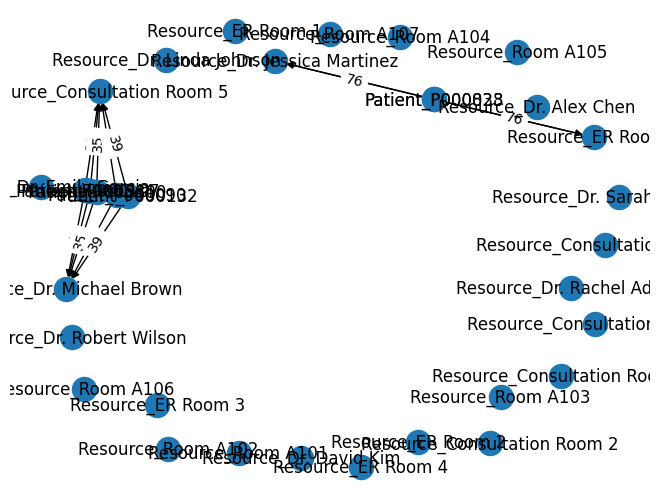

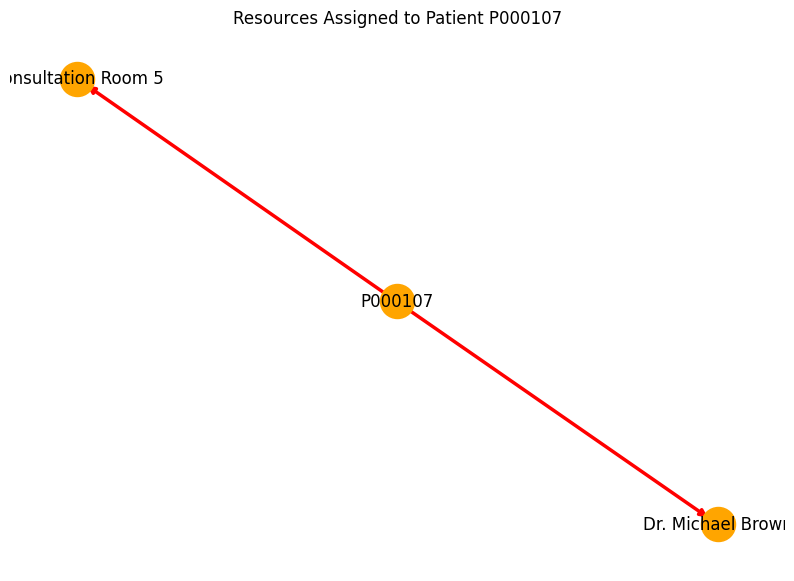

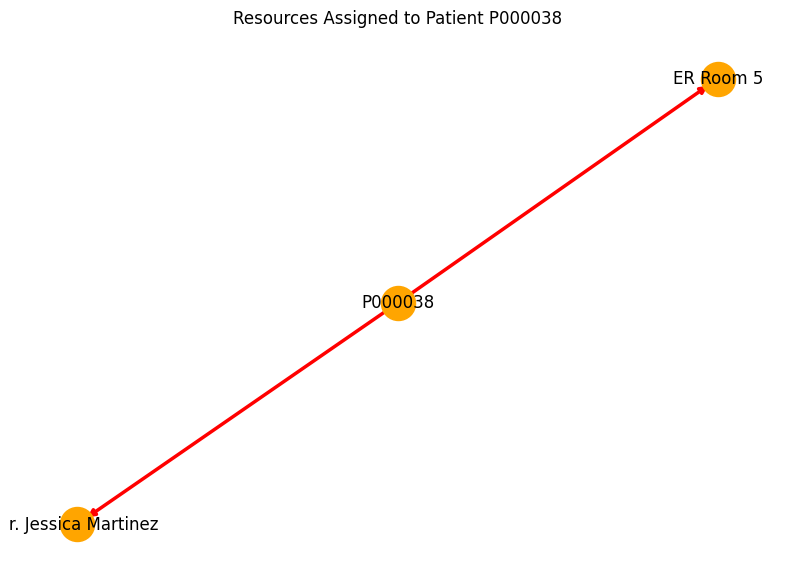

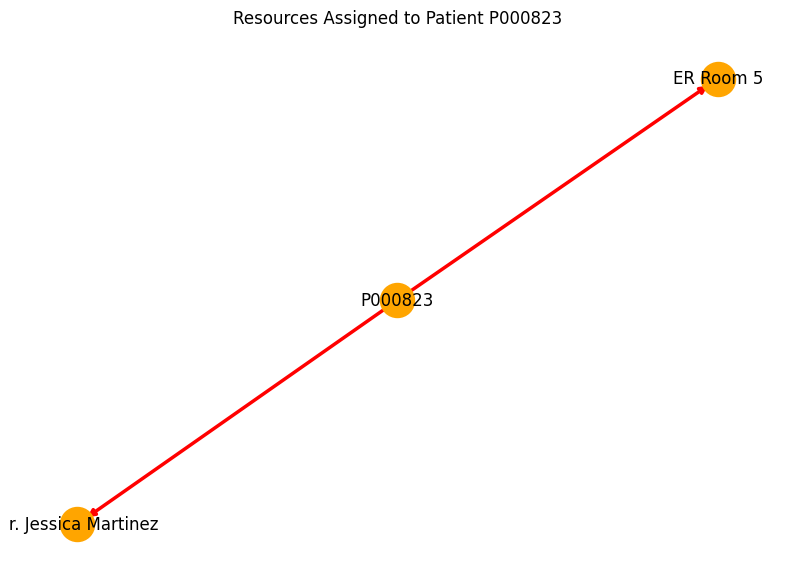

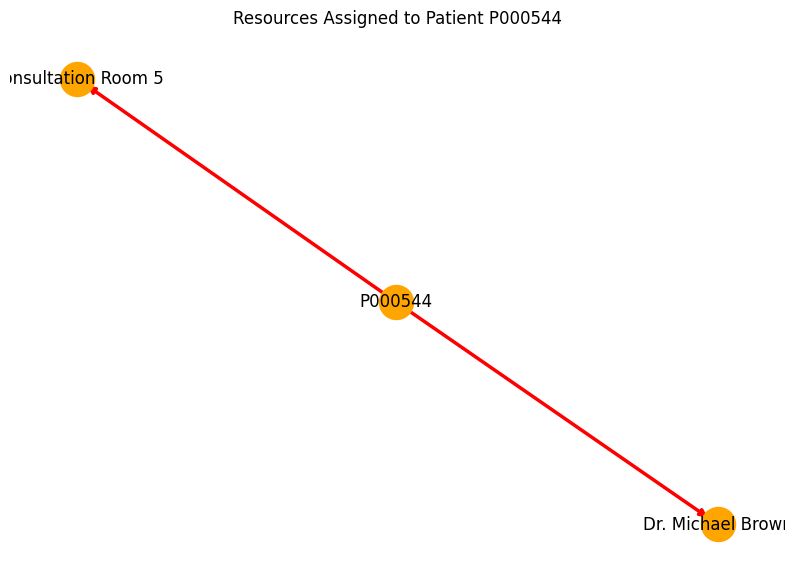

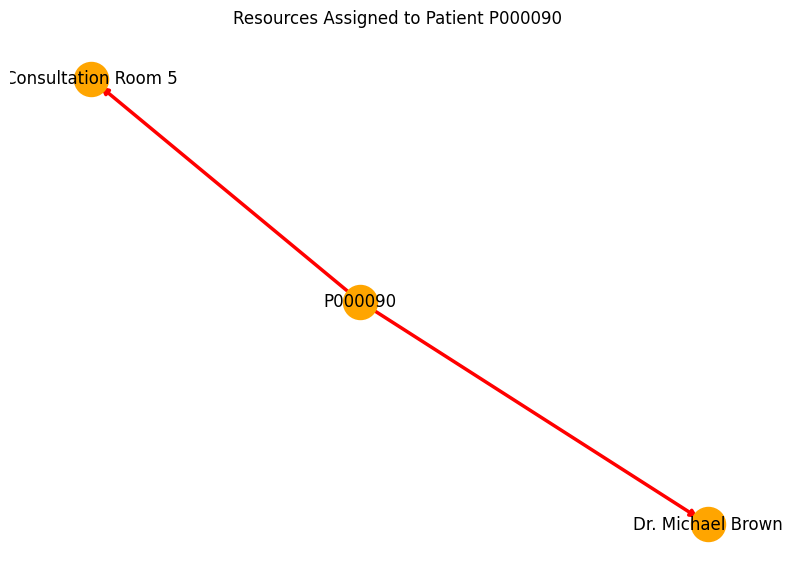

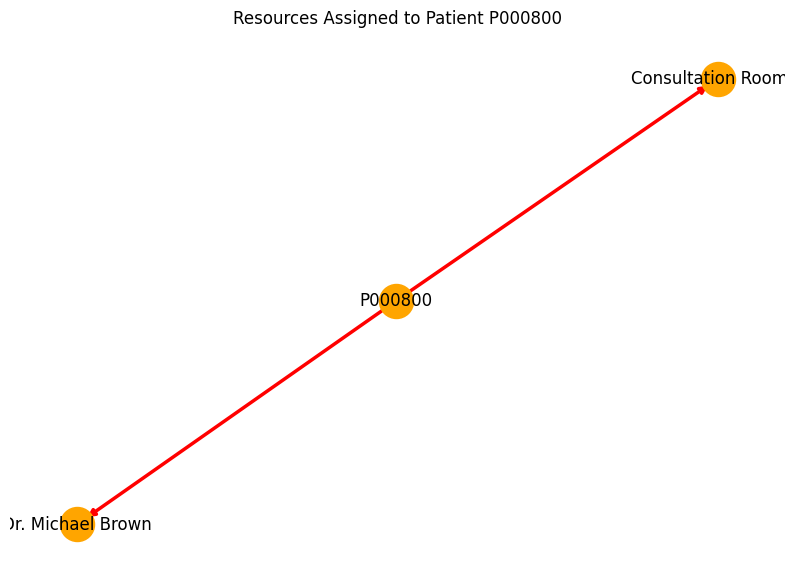

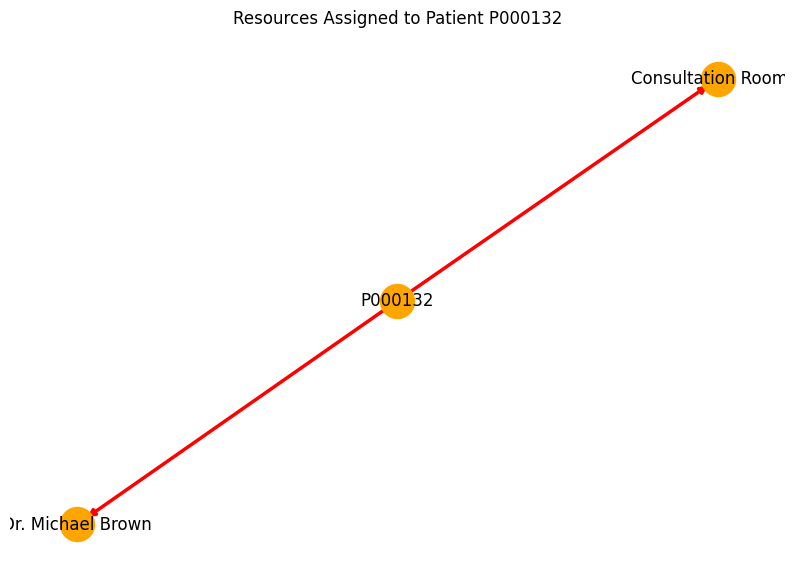

In [ ]:

def visualize_all_patient_resources(graph):
    all_patient_ids = [node_attr['patient_id']
                      for node, node_attr in graph.graph.nodes(data=True)
                      if node_attr.get('type') == 'patient']
    for patient_id in all_patient_ids:
        graph.visualize_patient_specific_resources(patient_id)

def generate_daily_reports(data_path, hospital_resources, date):
    # Load the data and create a new HospitalGraph instance
    hospital_graph = HospitalGraph(data_path, hospital_resources, date)
    # Check if graph creation was successful
    if hospital_graph.data.empty:
        return []
    hospital_graph.create_base_graph()

    assignments = hospital_graph.optimize_assignments()
    efficiencies = hospital_graph.calculate_efficiency()

    print("Assignments:", assignments)
    print("Efficiencies:", efficiencies)

    hospital_graph.visualize_graph_sl()
    visualize_all_patient_resources(hospital_graph)


# Example usage with your CSV file path and hospital resources dictionary:
data_path = "/content/healthcare_scheduling_combined_view_sample_1000 1.csv"
hospital_resources = {
    "TreatmentRooms": [
        {
            "room_id": "Room A101",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A102",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,  # Patient ID or None if empty
            "current_procedure": None,  # Procedure type or None if empty
            "start_time": None,  # Start time of current procedure
            "end_time": None,  # Estimated end time of current procedure
        },
        {
            "room_id": "Room A103",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A104",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A105",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A106",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A107",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
    ],
    "Specialists": [
        {
            "doctor_name": "Dr. Sarah Thompson",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 2,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 5
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Emily Garcia",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 2,
                "last_2_days": 0,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Alex Chen",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 1
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Rachel Adams",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 2,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 5
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
    ],

    "ConsultationRooms": [
        {
            "room_id": "Consultation Room 1",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 2",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 3",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 4",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 5",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        }
    ],
    "GeneralDoctors": [
        {
            "doctor_name": "Dr. Michael Brown",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 90,
            "overtime_hours": {
                "yesterday": 1,
                "day_before": 1,
                "last_2_days": 1,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Linda Johnson",
            "working_hours": {"start": "10:00", "end": "19:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 0,
                "last_2_days": 0,
                "last_week": 2
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Robert Wilson",
            "working_hours": {"start": "11:00", "end": "20:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 2,
                "last_2_days": 0,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        }
    ],
    "EmergencyRooms": [
        {
            "room_id": "ER Room 1",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 2",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 3",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 4",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 5",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        }
    ],
    "EmergencyDoctors": [
        {
            "doctor_name": "Dr. Jessica Martinez",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 90,
            "overtime_hours": {
                "yesterday": 1,
                "day_before": 1,
                "last_2_days": 1,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. David Kim",
            "working_hours": {"start": "09:00", "end": "18:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 0,
                "last_2_days": 0,
                "last_week": 2
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        }
    ]
}

date_to_process = "2024-08-05"
generate_daily_reports(data_path, hospital_resources, date_to_process)


"Efficiencies":{
   "Dr. Linda Johnson":92.5,
   "Dr. Robert Wilson":91.5,
   "Dr. Michael Brown":89.0,
   "Dr. Emily Garcia":90.0,
   "Dr. Alex Chen":86.0,
   "Dr. Sarah Thompson":82.0,
   "Dr. Rachel Adams":82.0,
   "Dr. David Kim":92.5,
   "Dr. Jessica Martinez":89.0
}

### date_to_process = "2024-08-04"

Patient P000367 arrived on 2024-08-04 at 10:15, had Urgent condition, and 57 priority score, waited 0.00 minutes before seeing Room A107 for 72 minutes.

Patient P000367 arrived on 2024-08-04 at 10:15, had Urgent condition, and 57 priority score, waited 0.00 minutes before seeing Dr. Rachel Adams for 72 minutes.



---


Patient P000329 arrived on 2024-08-04 at 08:00, had Urgent condition, and 50 priority score, waited 0.00 minutes before seeing Room A107 for 54 minutes.

Patient P000329 arrived on 2024-08-04 at 08:00, had Urgent condition, and 50 priority score, waited 0.00 minutes before seeing Dr. Rachel Adams for 54 minutes.



---


Patient P000665 arrived on 2024-08-04 at 12:15, had Routine condition, and 48 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 28 minutes.

Patient P000665 arrived on 2024-08-04 at 12:15, had Routine condition, and 48 priority score, waited 0.00 minutes before seeing Dr. Michael Brown for 28 minutes.


---



Patient P000116 arrived on 2024-08-04 at 08:45, had Routine condition, and 42 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 41 minutes.

Patient P000116 arrived on 2024-08-04 at 08:45, had Routine condition, and 42 priority score, waited 0.00 minutes before seeing Dr. Michael Brown for 41 minutes.


### Approach 3.i
Improved with dynamic checking


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class HospitalGraph:
    def __init__(self, data_path, hospital_resources, date):
        # Load data from CSV
        self.data = pd.read_csv(data_path)
        self.data['scheduled_date'] = pd.to_datetime(self.data['scheduled_date'])  # Convert to datetime

        # Filter data by date
        self.data = self.data[self.data['scheduled_date'] == pd.to_datetime(date)]

        # Check if data is empty for the given date
        if self.data.empty:
            print(f"No data found for {date}")
            return
        self.graph = nx.DiGraph()  # Directed graph for resource flow
        self.hospital_resources = hospital_resources  # Store hospital resources

        #self.resource_schedules = {resource: [] for category in hospital_resources.values() for resource in category}
        self.resource_schedules = {}
        for category, resources in hospital_resources.items():
            for resource in resources:
                if category in ["TreatmentRooms", "ConsultationRooms", "EmergencyRooms"]:
                    self.resource_schedules[resource["room_id"]] = []
                elif category in ["Specialists", "GeneralDoctors", "EmergencyDoctors"]:
                    self.resource_schedules[resource["doctor_name"]] = []


        # Define a mapping from specific resource types to their categories
        self.resource_mapping = {
            "TreatmentRoom": "TreatmentRooms",
            "Specialist": "Specialists",
            "ConsultationRoom": "ConsultationRooms",
            "GeneralDoctor": "GeneralDoctors",
            "EmergencyRoom": "EmergencyRooms",
            "EmergencyDoctor": "EmergencyDoctors"
        }

    def create_base_graph(self):
        # Extract unique resources from the dataset
        unique_resources = set()
        for _, row in self.data.iterrows():
            resources = row['required_resources'].split(',')
            unique_resources.update([r.strip() for r in resources])

        # # Add resource nodes to the graph
        # for resource in unique_resources:
        #     self.graph.add_node(f"Resource_{resource}", type='resource', capacity=1, schedule=[])
        # Add resource nodes - only specific resources
        for category, resources in self.hospital_resources.items():
            for resource in resources:
                resource_key = resource.get('room_id') or resource.get('doctor_name')
                self.graph.add_node(f"Resource_{resource_key}", type='resource', capacity=1, schedule=[])

        # Add patient nodes and connect them to required resources
        for _, row in self.data.iterrows():
            patient_node = f"Patient_{row['patient_id']}"
            self.graph.add_node(
                patient_node,
                type='patient',
                patient_id=row['patient_id'],
                priority_score=row['priority_score'],
                condition_type=row['condition_type'],
                wait_time_target=row['wait_time_target'],
                duration=row['duration_minutes'],
                scheduled_time=f"{row['scheduled_date']} {row['scheduled_time']}",
                required_resources=row['required_resources']
            )

            # Connect patient to required resources
            resources = row['required_resources'].split(',')
            for resource_type in resources:
                resource_category = self.resource_mapping.get(resource_type.strip())
                # Find the specific resource from the hospital_resources dictionary
                specific_resource = next((r for r in self.hospital_resources[resource_category] if resource_type.strip() in r.values()), None)
                if specific_resource:
                    resource_key = specific_resource.get('room_id') or specific_resource.get('doctor_name')  # Get the key for the resource
                    resource_node = f"Resource_{resource_key}"
                    self.graph.add_edge(patient_node, resource_node, weight=row['priority_score'])

    def optimize_assignments(self):
        """Optimize assignments of patients to specific resources."""
        patients = [(node, attr) for node, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']

        # Sort patients by priority score (descending) and wait time target (ascending)
        # patients.sort(key=lambda x: (-x[1]['priority_score'], x[1]['wait_time_target']))
        patients.sort(key=lambda x: (
            pd.to_datetime(x[1]['scheduled_time']).to_pydatetime(),  # scheduled_time ascending
            -x[1]['priority_score'],  # priority_score descending
            x[1]['wait_time_target']   # wait_time_target ascending
        ))


        efficiencies = self.calculate_efficiency()
        print("Efficiencies:", efficiencies)

        # Sort doctors by efficiency (higher first)
        for category in ['GeneralDoctors', 'Specialists', 'EmergencyDoctors']:
            self.hospital_resources[category].sort(
                key=lambda doc: efficiencies.get(doc["doctor_name"], 0), reverse=True
            )

        assignments = {}

        for patient, attr in patients:
            required_resources = attr['required_resources'].split(',')
            # scheduled_time = datetime.strptime(attr['scheduled_time'], '%Y-%m-%d %H:%M')
            scheduled_time = pd.to_datetime(attr['scheduled_time']).to_pydatetime()
            scheduled_time_formatted = scheduled_time.strftime('%H:%M')
            duration = attr['duration']
            patient_id = attr['patient_id']
            condition_type = attr['condition_type']

            for resource_type in required_resources:
                resource_category = self.resource_mapping.get(resource_type.strip())
                # if not resource_category:
                #     raise KeyError(f"Resource type '{resource_type}' not found in resource mapping.")

                available_resource = None
                min_wait_time = float('inf')

                # Check availability of specific resources within the category
                for specific_resource in self.hospital_resources[resource_category]:
                    # resource_schedule = self.resource_schedules[specific_resource]
                    # Use the 'room_id' or 'doctor_name' as the key for resource_schedules
                    resource_key = specific_resource.get('room_id') or specific_resource.get('doctor_name')
                    resource_schedule = self.resource_schedules[resource_key]
                    available_start = self._find_next_available_slot(resource_schedule, scheduled_time, duration)

                    wait_time = (available_start - scheduled_time).total_seconds() / 60
                    if wait_time < min_wait_time:
                        min_wait_time = wait_time
                        available_resource = specific_resource

                if available_resource:
                    # Assign this resource to the patient
                    available_start_formatted = available_start.strftime('%H:%M')
                    assignments[patient] = {
                        'resource': resource_key,
                        'start_time': available_start_formatted,
                        'duration': duration,
                        'scheduled_time': scheduled_time_formatted
                    }
                    # Update the resource's schedule
                    self._update_resource_schedule(resource_key, available_start, duration)

                    # Update hospital_resources
                    self._update_hospital_resources(patient_id, condition_type, scheduled_time, duration, resource_key, resource_type, resource_category)


                    # Add edge between patient and specific resource in the graph
                    self.graph.add_edge(patient, f"Resource_{resource_key}", weight=attr['priority_score'])

                    # Print patient assignment and waiting information
                    print(f"Patient {patient_id} arrived on {scheduled_time.strftime('%Y-%m-%d')} at {scheduled_time.strftime('%H:%M')}, had {condition_type} condition, and {attr['priority_score']} priority score, waited {wait_time:.2f} minutes before seeing {resource_key} for {duration} minutes.")


        return assignments

    def _find_next_available_slot(self, schedule, desired_time, duration):
        """Find the next available time slot for a resource."""
        if not schedule:
            return desired_time

        current_time = desired_time
        while True:
            conflict = False
            for start, end in schedule:
                if start <= current_time < end or start < current_time + timedelta(minutes=duration) <= end:
                    # Adjust to the end of conflicting slot + cleaning time if applicable
                    current_time = end  # Adjust to the end of conflicting slot
                    conflict = True
                    break

            if not conflict:
                # Find the resource details (room or doctor) from hospital_resources
                resource_details = None
                for category, resources in self.hospital_resources.items():
                    for resource in resources:
                        resource_key = resource.get('room_id') or resource.get('doctor_name')
                        if resource_key == resource:  # Assume resource name matches resource_key
                            resource_details = resource
                            break
                    if resource_details:
                        break

                # Add cleaning time to current_time if it's a room with cleaning_time
                if resource_details and 'cleaning_time' in resource_details:
                    current_time += timedelta(minutes=resource_details['cleaning_time'])

                return current_time

    def _update_resource_schedule(self, resource, start_time, duration):
        """Update the schedule of a specific resource."""
        end_time = start_time + timedelta(minutes=duration)
        self.resource_schedules[resource].append((start_time, end_time))

    # def _update_hospital_resources(self, patient_id, condition_type, scheduled_time, duration, resource_key, resource_type, resource_category):
    #     assigned_room_id = None
    #     for room in self.hospital_resources[resource_category]:
    #         if room.get('room_id') == resource_key:  # Check if room_id matches
    #             room["current_patient"] = patient_id
    #             room["current_procedure"] = condition_type
    #             # room["start_time"] = scheduled_time
    #             room["start_time"] = scheduled_time.strftime('%H:%M')
    #             # room["end_time"] = scheduled_time + timedelta(minutes=duration)
    #             room["end_time"] = (scheduled_time + timedelta(minutes=duration)).strftime('%H:%M')  # Format end_time
    #             assigned_room_id = room.get('room_id')
    #             break

    #     # Update doctor details in hospital_resources
    #     doctor_category = None  # Initialize doctor_category
    #     if resource_type in ["GeneralDoctor", "Specialist", "EmergencyDoctor"]:
    #         doctor_category = self.resource_mapping.get(resource_type)

    #     if doctor_category:
    #         for doctor in self.hospital_resources[doctor_category]:
    #             if doctor.get('doctor_name') == resource_key:  # Check if doctor_name matches
    #                 doctor["current_patient"] = patient_id
    #                 doctor["current_room"] = assigned_room_id
    #                 doctor["patients_seen_today"].append(patient_id)
    #                 break
    #     print("Updated hospital_resources:")
    #     print(self.hospital_resources)

    def _update_hospital_resources(self, patient_id, condition_type, scheduled_time, duration, resource_key, resource_type, resource_category):
        """Update hospital resources and doctor efficiency."""

        # Initialize assigned_room_id to None
        assigned_room_id = None

        # Check if the resource is a room and update room status
        if resource_type in ['TreatmentRoom', 'ConsultationRoom', 'EmergencyRoom']:
            for room in self.hospital_resources[resource_category]:
                if room.get('room_id') == resource_key:
                    # Update room details if found
                    room["status"] = "occupied"
                    room["current_patient"] = patient_id
                    room["current_procedure"] = condition_type  # Or some procedure code
                    room["start_time"] = scheduled_time
                    room["end_time"] = scheduled_time + timedelta(minutes=duration)
                    assigned_room_id = room.get('room_id')  # Store the assigned room ID
                    print("Updated room:", room)
                    break

        # Update doctor efficiency and assign room (if applicable)
        efficiency_reduction = 0
        if resource_type == "EmergencyDoctor":
            efficiency_reduction = 10
        elif resource_type == "Specialist":
            efficiency_reduction = 6
        elif resource_type == "GeneralDoctor":
            efficiency_reduction = 2

        for doctor in self.hospital_resources[resource_category]:
            if doctor.get('doctor_name') == resource_key:
                doctor["current_patient"] = patient_id
                doctor["current_room"] = assigned_room_id  # Assign the room ID
                doctor["patients_seen_today"].append(patient_id)
                doctor["well_rested_score"] = max(0, doctor["well_rested_score"] - efficiency_reduction)
                print("Updated doctor:", doctor)
                break
            # print("Updated hospital_resources:")
            # print(self.hospital_resources)

    def calculate_efficiency(self):
        efficiencies = {}

        for category in ['GeneralDoctors', 'Specialists', 'EmergencyDoctors']:
            for doctor in self.hospital_resources[category]:
                efficiency_base = 95  # Base efficiency percentage

                if not doctor["lunch_break"]:
                    efficiency_base -= 5

                overtime_penalty = doctor["overtime_hours"]["last_2_days"] * 2 + doctor["overtime_hours"]["last_week"]

                well_rested_penalty = max(0, 100 - doctor["well_rested_score"]) / 10

                patients_seen_penalty = len(doctor["patients_seen_today"])
                if category == 'GeneralDoctors':
                    patients_seen_penalty *= 0.5
                elif category == 'Specialists':
                    patients_seen_penalty *= 1.0
                elif category == 'EmergencyDoctors':
                    patients_seen_penalty *= 1.5

                total_penalty = overtime_penalty + well_rested_penalty + patients_seen_penalty
                efficiencies[doctor["doctor_name"]] = max(0, efficiency_base - total_penalty)

        return efficiencies

    def visualize_graph_sl(self):
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True)
        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)
        plt.show()

    def visualize_patient_specific_resources(graph, patient_id):
        plt.figure(figsize=(10, 7))
        pos = nx.spring_layout(graph.graph)

        patient_node = f"Patient_{patient_id}"
        # Filter edges to include only those connected to the specified patient
        edges_to_highlight = [(u, v) for u, v in graph.graph.edges() if u == patient_node or v == patient_node]

        # Filter nodes to include only the patient and connected resources
        nodes_to_highlight = [patient_node] + [v for u, v in edges_to_highlight if v != patient_node] + [u for u, v in edges_to_highlight if u != patient_node]

        # Create a subgraph containing only the highlighted nodes and edges
        subgraph = graph.graph.subgraph(nodes_to_highlight)

        # Draw nodes and edges of the subgraph
        nx.draw_networkx_nodes(subgraph, pos, node_color='orange', node_size=600)
        nx.draw_networkx_edges(subgraph, pos, edge_color='red', width=2.5)

        # Add labels to the nodes
        labels = {node: node.split('_')[1] for node in subgraph.nodes()}
        nx.draw_networkx_labels(subgraph, pos, labels)

        plt.title(f"Resources Assigned to Patient {patient_id}")
        plt.axis('off')
        plt.show()


Efficiencies: {'Dr. Michael Brown': 89.0, 'Dr. Linda Johnson': 92.5, 'Dr. Robert Wilson': 91.5, 'Dr. Sarah Thompson': 82.0, 'Dr. Emily Garcia': 90.0, 'Dr. Alex Chen': 86.0, 'Dr. Rachel Adams': 82.0, 'Dr. Jessica Martinez': 89.0, 'Dr. David Kim': 92.5}
Updated room: {'room_id': 'Consultation Room 5', 'status': 'occupied', 'last_cleaned': '2024-08-01 12:34:56', 'cleaning_time': 1, 'current_patient': 'P000132', 'current_procedure': 'Routine', 'start_time': datetime.datetime(2024, 8, 5, 8, 45), 'end_time': datetime.datetime(2024, 8, 5, 9, 12)}
Patient P000132 arrived on 2024-08-05 at 08:45, had Routine condition, and 39 priority score, waited 0.00 minutes before seeing Consultation Room 5 for 27 minutes.
Updated doctor: {'doctor_name': 'Dr. Michael Brown', 'working_hours': {'start': '08:00', 'end': '17:00'}, 'well_rested_score': 88, 'overtime_hours': {'yesterday': 1, 'day_before': 1, 'last_2_days': 1, 'last_week': 3}, 'lunch_break': True, 'current_patient': 'P000132', 'current_room': None,

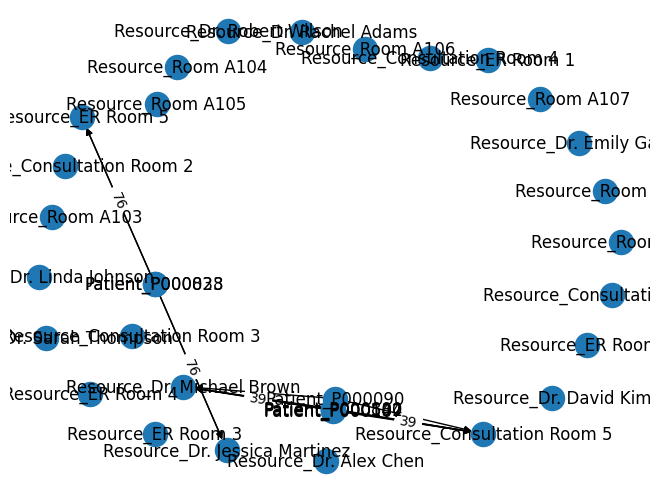

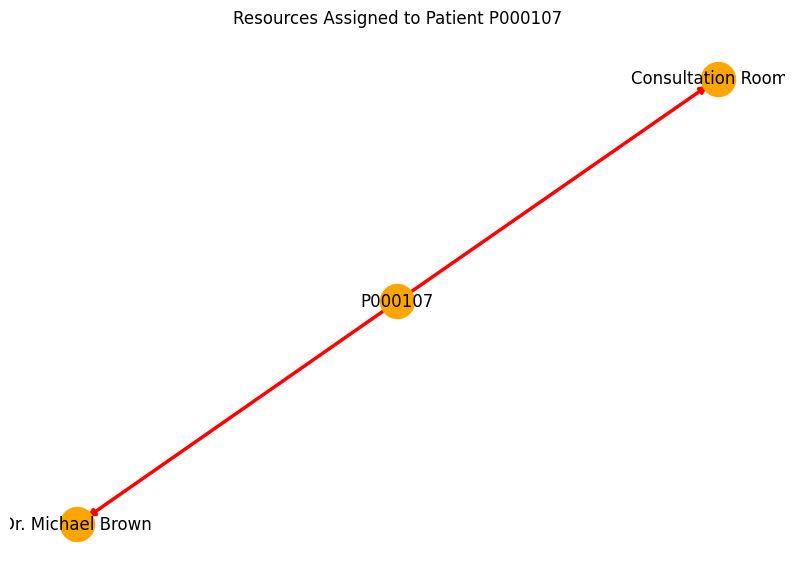

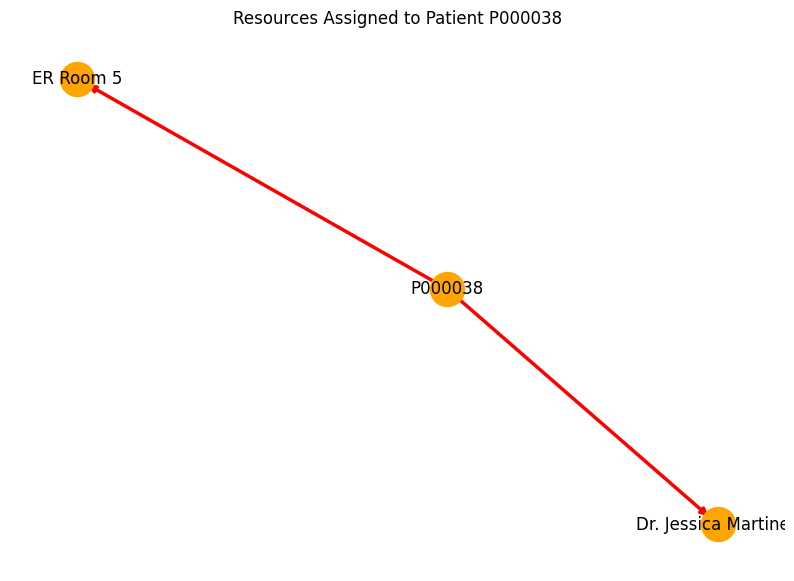

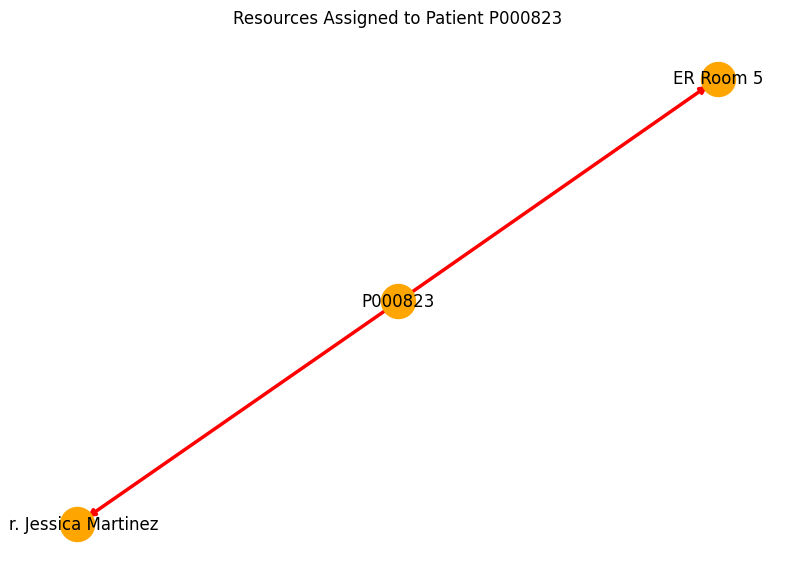

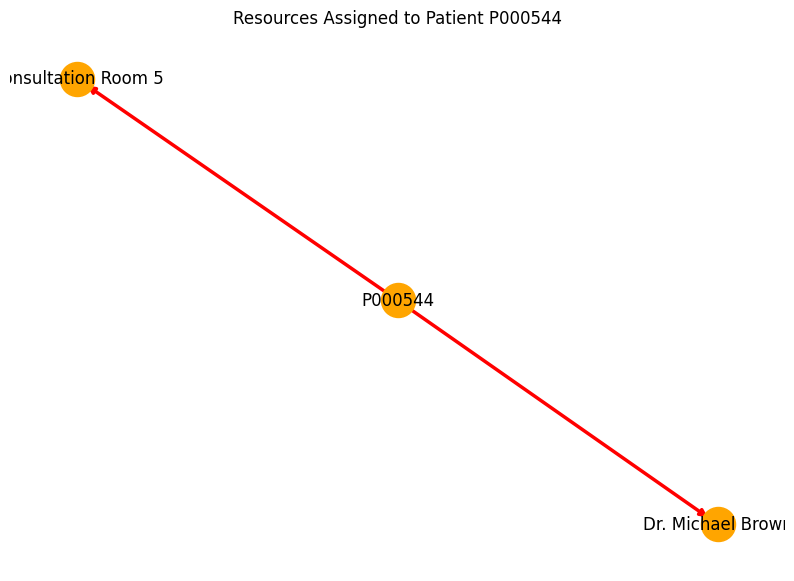

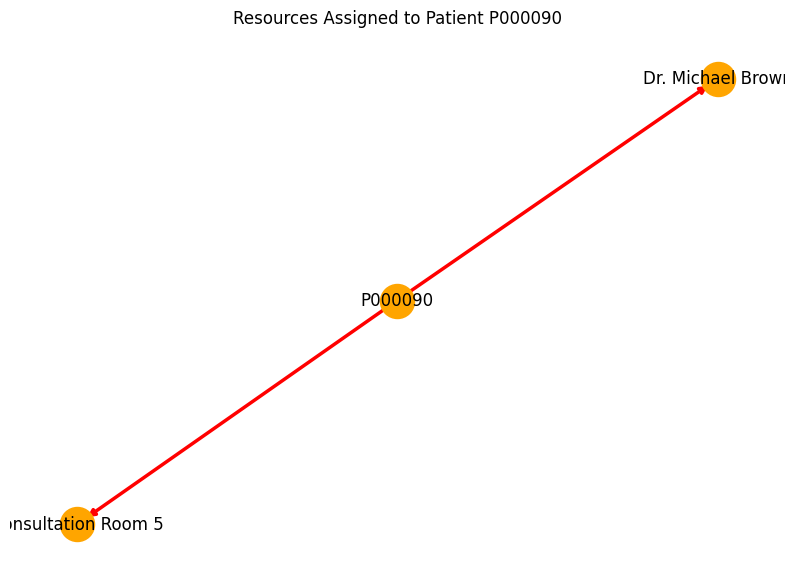

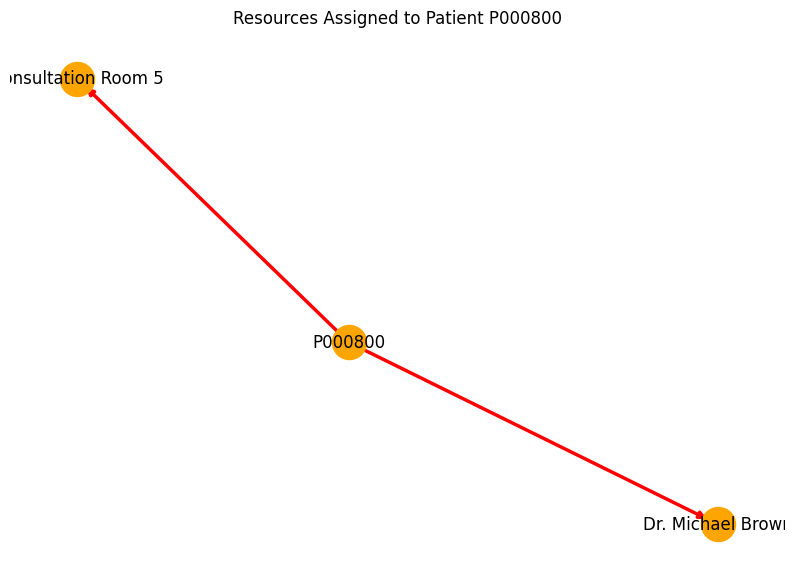

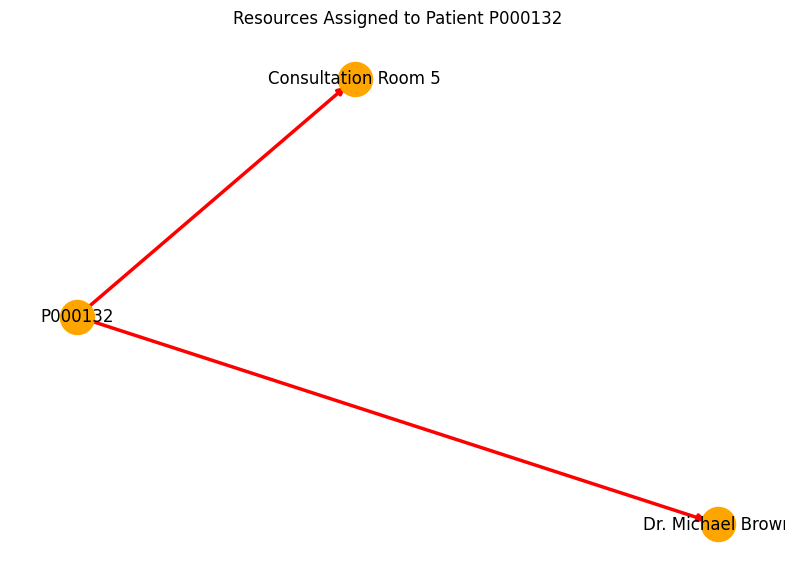

In [ ]:

def visualize_all_patient_resources(graph):
    all_patient_ids = [node_attr['patient_id']
                      for node, node_attr in graph.graph.nodes(data=True)
                      if node_attr.get('type') == 'patient']
    for patient_id in all_patient_ids:
        graph.visualize_patient_specific_resources(patient_id)

def generate_daily_reports(data_path, hospital_resources, date):
    # Load the data and create a new HospitalGraph instance
    hospital_graph = HospitalGraph(data_path, hospital_resources, date)
    # Check if graph creation was successful
    if hospital_graph.data.empty:
        return []
    hospital_graph.create_base_graph()

    assignments = hospital_graph.optimize_assignments()
    efficiencies = hospital_graph.calculate_efficiency()

    print("Assignments:", assignments)
    print("Efficiencies:", efficiencies)

    hospital_graph.visualize_graph_sl()
    visualize_all_patient_resources(hospital_graph)


# Example usage with your CSV file path and hospital resources dictionary:
data_path = "/content/healthcare_scheduling_combined_view_sample_1000 1.csv"
hospital_resources = {
    "TreatmentRooms": [
        {
            "room_id": "Room A101",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A102",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,  # Patient ID or None if empty
            "current_procedure": None,  # Procedure type or None if empty
            "start_time": None,  # Start time of current procedure
            "end_time": None,  # Estimated end time of current procedure
        },
        {
            "room_id": "Room A103",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A104",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A105",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A106",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Room A107",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 5,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
    ],
    "Specialists": [
        {
            "doctor_name": "Dr. Sarah Thompson",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 2,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 5
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Emily Garcia",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 2,
                "last_2_days": 0,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Alex Chen",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 1
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Rachel Adams",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 80,
            "overtime_hours": {
                "yesterday": 2,
                "day_before": 1,
                "last_2_days": 3,
                "last_week": 5
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
    ],

    "ConsultationRooms": [
        {
            "room_id": "Consultation Room 1",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 2",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 3",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 4",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "Consultation Room 5",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 1,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        }
    ],
    "GeneralDoctors": [
        {
            "doctor_name": "Dr. Michael Brown",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 90,
            "overtime_hours": {
                "yesterday": 1,
                "day_before": 1,
                "last_2_days": 1,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Linda Johnson",
            "working_hours": {"start": "10:00", "end": "19:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 0,
                "last_2_days": 0,
                "last_week": 2
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. Robert Wilson",
            "working_hours": {"start": "11:00", "end": "20:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 2,
                "last_2_days": 0,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        }
    ],
    "EmergencyRooms": [
        {
            "room_id": "ER Room 1",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 2",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 3",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 4",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        },
        {
            "room_id": "ER Room 5",
            "status": "available",
            "last_cleaned": "2024-08-01 12:34:56",
            "cleaning_time": 25,
            "current_patient": None,
            "current_procedure": None,
            "start_time": None,
            "end_time": None,
        }
    ],
    "EmergencyDoctors": [
        {
            "doctor_name": "Dr. Jessica Martinez",
            "working_hours": {"start": "08:00", "end": "17:00"},
            "well_rested_score": 90,
            "overtime_hours": {
                "yesterday": 1,
                "day_before": 1,
                "last_2_days": 1,
                "last_week": 3
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        },
        {
            "doctor_name": "Dr. David Kim",
            "working_hours": {"start": "09:00", "end": "18:00"},
            "well_rested_score": 95,
            "overtime_hours": {
                "yesterday": 0,
                "day_before": 0,
                "last_2_days": 0,
                "last_week": 2
            },
            "lunch_break": True,
            "current_patient": None,
            "current_room": None,
            "patients_seen_today": []
        }
    ]
}

date_to_process = "2024-08-05"
generate_daily_reports(data_path, hospital_resources, date_to_process)




```
"Assignments":{
   "Patient_P000132":{
      "resource":"Dr. Michael Brown",
      "start_time":"08:45",
      "duration":27,
      "scheduled_time":"08:45"
   },
   "Patient_P000090":{
      "resource":"Dr. Michael Brown",
      "start_time":"09:45",
      "duration":26,
      "scheduled_time":"09:45"
   },
   "Patient_P000800":{
      "resource":"Dr. Michael Brown",
      "start_time":"11:45",
      "duration":21,
      "scheduled_time":"11:45"
   },
   "Patient_P000038":{
      "resource":"Dr. Jessica Martinez",
      "start_time":"15:00",
      "duration":45,
      "scheduled_time":"15:00"
   },
   "Patient_P000823":{
      "resource":"Dr. Jessica Martinez",
      "start_time":"15:45",
      "duration":34,
      "scheduled_time":"15:30"
   },
   "Patient_P000544":{
      "resource":"Dr. Michael Brown",
      "start_time":"16:45",
      "duration":27,
      "scheduled_time":"16:45"
   },
   "Patient_P000107":{
      "resource":"Dr. Michael Brown",
      "start_time":"19:00",
      "duration":15,
      "scheduled_time":"19:00"
   }
}
```





```
{
   "TreatmentRooms":[
      {
         "room_id":"Room A101",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A102",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A103",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A104",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A105",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A106",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Room A107",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":5,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      }
   ],
   "Specialists":[
      {
         "doctor_name":"Dr. Emily Garcia",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":80,
         "overtime_hours":{
            "yesterday":0,
            "day_before":2,
            "last_2_days":0,
            "last_week":3
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Alex Chen",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":80,
         "overtime_hours":{
            "yesterday":0,
            "day_before":1,
            "last_2_days":3,
            "last_week":1
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Sarah Thompson",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":80,
         "overtime_hours":{
            "yesterday":2,
            "day_before":1,
            "last_2_days":3,
            "last_week":5
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Rachel Adams",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":80,
         "overtime_hours":{
            "yesterday":2,
            "day_before":1,
            "last_2_days":3,
            "last_week":5
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      }
   ],
   "ConsultationRooms":[
      {
         "room_id":"Consultation Room 1",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":1,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Consultation Room 2",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":1,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Consultation Room 3",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":1,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Consultation Room 4",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":1,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"Consultation Room 5",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":1,
         "current_patient":"P000107",
         "current_procedure":"Routine",
         "start_time":"19:00",
         "end_time":"19:15"
      }
   ],
   "GeneralDoctors":[
      {
         "doctor_name":"Dr. Linda Johnson",
         "working_hours":{
            "start":"10:00",
            "end":"19:00"
         },
         "well_rested_score":95,
         "overtime_hours":{
            "yesterday":0,
            "day_before":0,
            "last_2_days":0,
            "last_week":2
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Robert Wilson",
         "working_hours":{
            "start":"11:00",
            "end":"20:00"
         },
         "well_rested_score":95,
         "overtime_hours":{
            "yesterday":0,
            "day_before":2,
            "last_2_days":0,
            "last_week":3
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Michael Brown",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":90,
         "overtime_hours":{
            "yesterday":1,
            "day_before":1,
            "last_2_days":1,
            "last_week":3
         },
         "lunch_break":true,
         "current_patient":"P000107",
         "current_room":"None",
         "patients_seen_today":[
            "P000132",
            "P000090",
            "P000800",
            "P000544",
            "P000107"
         ]
      }
   ],
   "EmergencyRooms":[
      {
         "room_id":"ER Room 1",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":25,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"ER Room 2",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":25,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"ER Room 3",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":25,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"ER Room 4",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":25,
         "current_patient":"None",
         "current_procedure":"None",
         "start_time":"None",
         "end_time":"None"
      },
      {
         "room_id":"ER Room 5",
         "status":"available",
         "last_cleaned":"2024-08-01 12:34:56",
         "cleaning_time":25,
         "current_patient":"P000823",
         "current_procedure":"Emergency",
         "start_time":"15:30",
         "end_time":"16:04"
      }
   ],
   "EmergencyDoctors":[
      {
         "doctor_name":"Dr. David Kim",
         "working_hours":{
            "start":"09:00",
            "end":"18:00"
         },
         "well_rested_score":95,
         "overtime_hours":{
            "yesterday":0,
            "day_before":0,
            "last_2_days":0,
            "last_week":2
         },
         "lunch_break":true,
         "current_patient":"None",
         "current_room":"None",
         "patients_seen_today":[
            
         ]
      },
      {
         "doctor_name":"Dr. Jessica Martinez",
         "working_hours":{
            "start":"08:00",
            "end":"17:00"
         },
         "well_rested_score":90,
         "overtime_hours":{
            "yesterday":1,
            "day_before":1,
            "last_2_days":1,
            "last_week":3
         },
         "lunch_break":true,
         "current_patient":"P000823",
         "current_room":"None",
         "patients_seen_today":[
            "P000038",
            "P000823"
         ]
      }
   ]
}
```



# Apporach 4

This approach uses the Dijkstra algorithm to implement a hospital resource allocation system. It simulates the distribution relationship between patients and resources in the form of a directed graph and tries to optimize the use of resources. The output is like apporaches above.





In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json

class HospitalGraph:
    def __init__(self, data_path, hospital_resources):
        # Load data from CSV
        self.data = pd.read_csv(data_path)
        self.graph = nx.DiGraph()  # Directed graph for resource flow
        self.hospital_resources = hospital_resources  # Store hospital resources
        self.resource_schedules = {resource: [] for category in hospital_resources.values() for resource in category}

        # Define a mapping from specific resource types to their categories
        self.resource_mapping = {
            "TreatmentRoom": "TreatmentRooms",
            "Specialist": "Specialists",
            "ConsultationRoom": "ConsultationRooms",
            "GeneralDoctor": "GeneralDoctors",
            "EmergencyRoom": "EmergencyRooms",
            "EmergencyDoctor": "EmergencyDoctors"
        }

    def create_base_graph(self):
        """
        Create a directed graph with patient nodes and resource nodes.
        Add edges between patients and their required resources.
        """
        # Extract unique resources from the dataset
        unique_resources = set()
        for _, row in self.data.iterrows():
            resources = row['required_resources'].split(',')
            unique_resources.update([r.strip() for r in resources])

        # Add resource nodes to the graph
        for resource in unique_resources:
            self.graph.add_node(f"Resource_{resource}", type='resource', capacity=1, schedule=[])

        # Add patient nodes and connect them to required resources
        for _, row in self.data.iterrows():
            patient_node = f"Patient_{row['patient_id']}"
            self.graph.add_node(
                patient_node,
                type='patient',
                priority_score=row['priority_score'],
                condition_type=row['condition_type'],
                wait_time_target=row['wait_time_target'],
                duration=row['duration_minutes'],
                scheduled_time=f"{row['scheduled_date']} {row['scheduled_time']}",
                required_resources=row['required_resources']
            )
            # Connect patient to required resources
            resources = row['required_resources'].split(',')
            for resource in resources:
                resource_node = f"Resource_{resource.strip()}"
                self.graph.add_edge(patient_node, resource_node, weight=row['priority_score'])

    def optimize_assignments_dijkstra(self):
        """
        Use Dijkstra's algorithm to optimize assignments of patients to resources.
        """
        assignments = {}
        for patient, attr in self.graph.nodes(data=True):
            if attr.get('type') == 'patient':
                scheduled_time = datetime.strptime(attr['scheduled_time'], '%Y-%m-%d %H:%M')
                duration = attr['duration']
                required_resources = attr['required_resources'].split(',')

                for resource_type in required_resources:
                    resource_category = self.resource_mapping.get(resource_type.strip())
                    if not resource_category:
                        raise KeyError(f"Resource type '{resource_type}' not found in resource mapping.")

                    available_resource = None
                    min_wait_time = float('inf')

                    # Use Dijkstra's algorithm to find shortest available resource
                    for specific_resource in self.hospital_resources[resource_category]:
                        resource_schedule = self.resource_schedules[specific_resource]
                        available_start = self._find_next_available_slot(resource_schedule, scheduled_time, duration)
                        wait_time = (available_start - scheduled_time).total_seconds() / 60

                        if wait_time < min_wait_time:
                            min_wait_time = wait_time
                            available_resource = specific_resource

                    if available_resource:
                        # Assign the resource and update its schedule
                        assignments[patient] = {
                            'resource': available_resource,
                            'start_time': available_start,
                            'duration': duration
                        }
                        self._update_resource_schedule(available_resource, available_start, duration)
                        self.graph.add_edge(patient, f"Resource_{available_resource}", weight=attr['priority_score'])
        return assignments

    def _find_next_available_slot(self, schedule, desired_time, duration):
        """
        Find the next available time slot for a resource.
        """
        if not schedule:
            return desired_time

        current_time = desired_time
        while True:
            conflict = False
            for start, end in schedule:
                if start <= current_time < end or start < current_time + timedelta(minutes=duration) <= end:
                    current_time = end  # Adjust to the end of conflicting slot
                    conflict = True
                    break

            if not conflict:
                return current_time

    def _update_resource_schedule(self, resource, start_time, duration):
        """
        Update the schedule of a specific resource.
        """
        end_time = start_time + timedelta(minutes=duration)
        self.resource_schedules[resource].append((start_time, end_time))

    def visualize_all_patients_resources(self):
        """
        Visualize all patients and their assigned resources.
        Nodes are colored based on type: patients and resources.
        """
        plt.figure(figsize=(12, 9))
        pos = nx.spring_layout(self.graph, seed=42)

        # Separate patients and resources
        patient_nodes = [node for node, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']
        resource_nodes = [node for node, attr in self.graph.nodes(data=True) if attr['type'] == 'resource']

        # Draw patient nodes and resource nodes
        nx.draw_networkx_nodes(self.graph, pos, nodelist=patient_nodes, node_color='orange', node_size=600, label="Patients")
        nx.draw_networkx_nodes(self.graph, pos, nodelist=resource_nodes, node_color='lightblue', node_size=600, label="Resources")

        # Draw edges
        nx.draw_networkx_edges(self.graph, pos, edge_color='gray', arrows=True)

        # Add labels
        labels = {node: node.split('_')[1] for node in self.graph.nodes}
        nx.draw_networkx_labels(self.graph, pos, labels, font_size=9)

        plt.title("Visualization of Patients and Their Assigned Resources")
        plt.legend()
        plt.axis('off')
        plt.show()

# Hospital resources
hospital_resources = {
    "TreatmentRooms": [
        "Room A101", "Room A102", "Room A103"
    ],
    "Specialists": [
        "Dr. Sarah Thompson", "Dr. Emily Garcia"
    ],
    "ConsultationRooms": [
        "Consultation Room 1", "Consultation Room 2"
    ],
    "GeneralDoctors": [
        "Dr. Michael Brown", "Dr. Linda Johnson"
    ],
    "EmergencyRooms": [
        "ER Room 1", "ER Room 2"
    ],
    "EmergencyDoctors": [
        "Dr. Jessica Martinez"
    ]
}



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class HospitalGraph:
    def __init__(self, data_path, hospital_resources, date):
        # Initialize with data and resources
        self.graph = nx.Graph()
        self.data_path = data_path
        self.hospital_resources = hospital_resources
        self.date = date
        self.data = pd.read_csv(data_path)

    def create_base_graph(self):
        # Create graph structure from data and resources
        for resource_type, resources in self.hospital_resources.items():
            for resource in resources:
                self.graph.add_node(resource["room_id"] if "room_id" in resource else resource["doctor_name"],
                                    type=resource_type)

        for _, patient in self.data.iterrows():
            self.graph.add_node(patient["patient_id"], type="patient")

    def optimize_assignments_dijkstra(self):
        # Example: Apply Dijkstra algorithm (stub for actual implementation)
        assignments = []
        for patient_node in self.graph.nodes(data=True):
            if patient_node[1].get("type") == "patient":
                for resource_node in self.graph.nodes(data=True):
                    if resource_node[1].get("type") in ["TreatmentRooms", "Specialists"]:
                        weight = self.calculate_weight(patient_node[0], resource_node[0])
                        self.graph.add_edge(patient_node[0], resource_node[0], weight=weight)
                # Dijkstra to find the optimal assignment
                shortest_path = nx.single_source_dijkstra_path(self.graph, patient_node[0])
                assignments.append(shortest_path)
        return assignments

    def calculate_weight(self, patient, resource):
        # Custom weight calculation (stub for now)
        return 1

    def visualize_graph_dijkstra(self):
        # Visualize the graph with the Dijkstra paths highlighted
        pos = nx.spring_layout(self.graph)  # Layout for visualization

        # Draw nodes
        patient_nodes = [n for n, attr in self.graph.nodes(data=True) if attr['type'] == 'patient']
        resource_nodes = [n for n, attr in self.graph.nodes(data=True) if attr['type'] != 'patient']

        nx.draw_networkx_nodes(self.graph, pos, nodelist=patient_nodes, node_color='blue', label='Patients')
        nx.draw_networkx_nodes(self.graph, pos, nodelist=resource_nodes, node_color='green', label='Resources')

        # Draw edges
        nx.draw_networkx_edges(self.graph, pos, edgelist=self.graph.edges, alpha=0.5)

        # Highlight shortest paths (example)
        for patient_node in patient_nodes:
            paths = nx.single_source_dijkstra_path(self.graph, patient_node)
            for path in paths.values():
                nx.draw_networkx_edges(self.graph, pos,
                                       edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)],
                                       edge_color='red', width=2)

        # Draw labels
        nx.draw_networkx_labels(self.graph, pos)

        # Add legend
        plt.legend()
        plt.title("Hospital Resource Allocation - Dijkstra Visualization")
        plt.show()
